In [ ]:
!pip install nltk
!pip install vaderSentiment
!pip install scikit-learn
!pip install pandas
!pip install yfinance


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 7.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab') # Download the punkt_tab model for tokenization


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if isinstance(text, str):
        text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special chars
        text = text.lower()
        tokens = nltk.word_tokenize(text)
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
        return ' '.join(tokens)
    return ""

# Load your dataset
df = pd.read_csv('/content/dataset_52-person-from-2021-02-05_2023-06-12_21-34-17-266_with_sentiment.csv', encoding='ISO-8859-1')
df = df.dropna(subset=['full_text'])
df['clean_text'] = df['full_text'].apply(preprocess_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


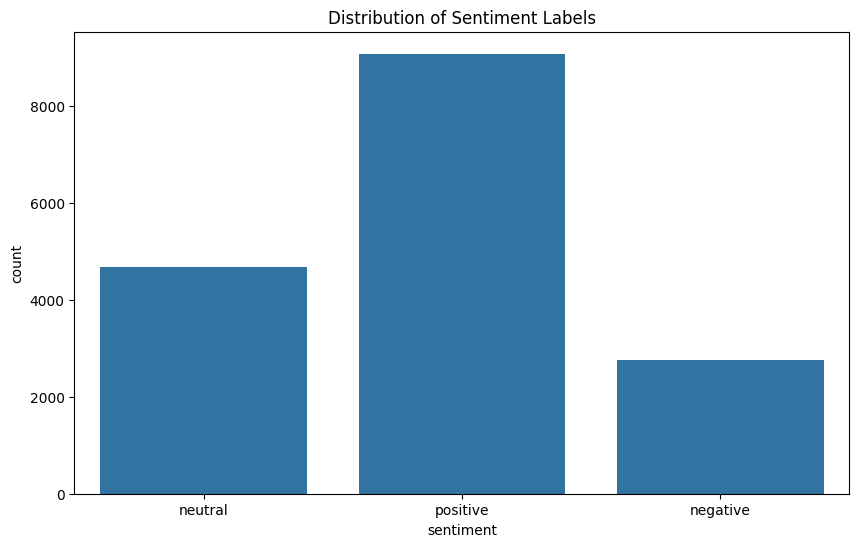

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from statsmodels.tsa.stattools import ccf
# Plot sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiment Labels')
plt.show()

In [ ]:
print(f"Total entries: {len(df)}")
print(f"Unique sentiments: {df['sentiment'].nunique()}")
print(f"Date range: {df['created_at'].min()} to {df['created_at'].max()}")

Total entries: 16512
Unique sentiments: 3
Date range: 1/1/2022 to 9/9/2022


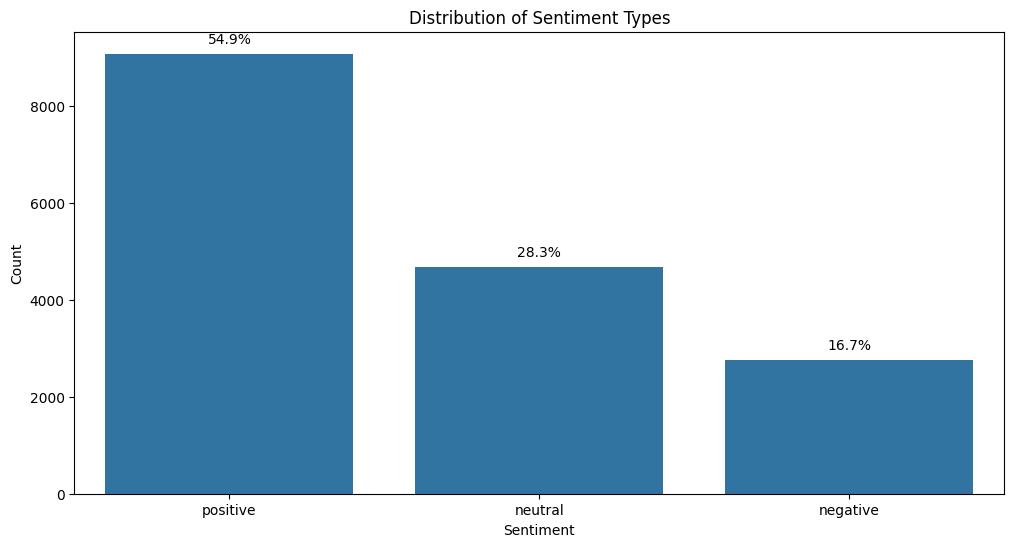

In [ ]:
plt.figure(figsize=(12,6))
ax = sns.countplot(x='sentiment', data=df, order=df['sentiment'].value_counts().index)
plt.title('Distribution of Sentiment Types')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Add percentages
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height()/total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='center', xytext=(0,10), textcoords='offset points')
plt.show()

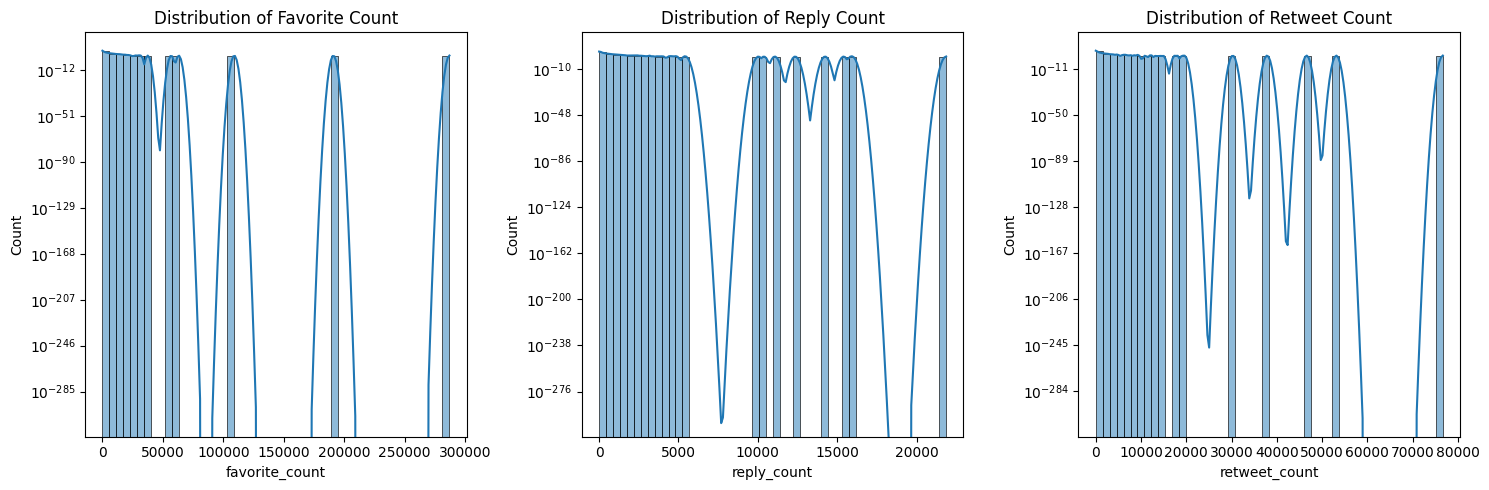

In [ ]:
engagement_metrics = ['favorite_count', 'reply_count', 'retweet_count']
plt.figure(figsize=(15,5))
for i, col in enumerate(engagement_metrics, 1):
    plt.subplot(1,3,i)
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f'Distribution of {col.replace("_", " ").title()}')
    plt.yscale('log')  # Many social metrics have long-tailed distributions
plt.tight_layout()
plt.show()

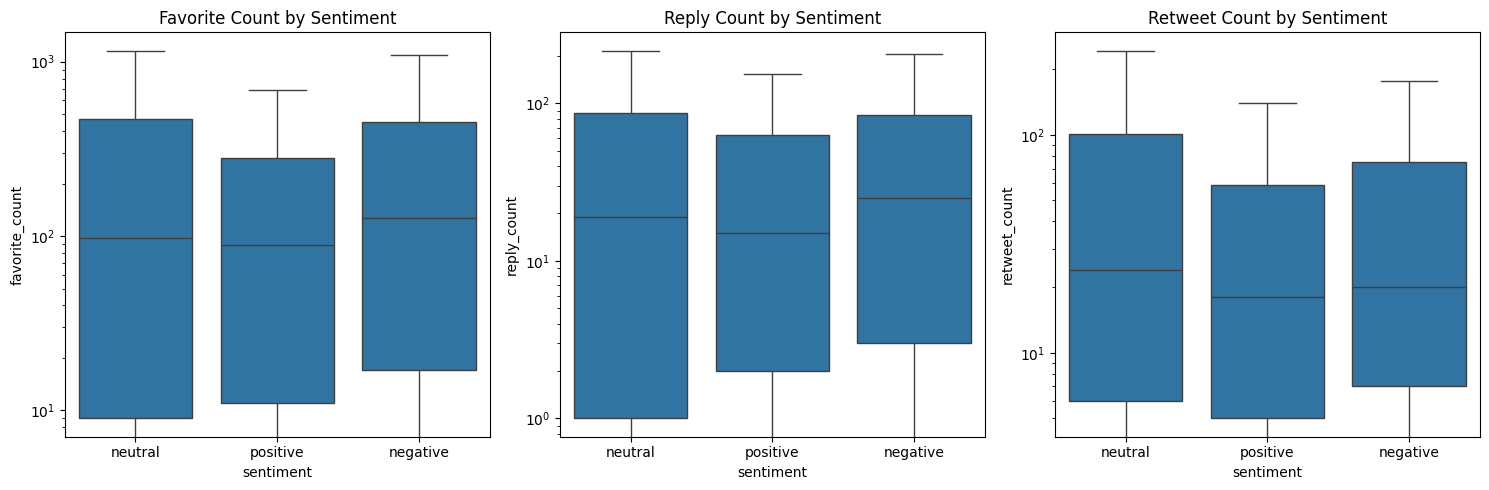

In [ ]:
plt.figure(figsize=(15,5))
for i, metric in enumerate(engagement_metrics, 1):
    plt.subplot(1,3,i)
    sns.boxplot(x='sentiment', y=metric, data=df, showfliers=False)
    plt.title(f'{metric.replace("_", " ").title()} by Sentiment')
    plt.yscale('log')
plt.tight_layout()
plt.show()

<ipython-input-16-4e87c82b496a>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour', data=df, palette='viridis')


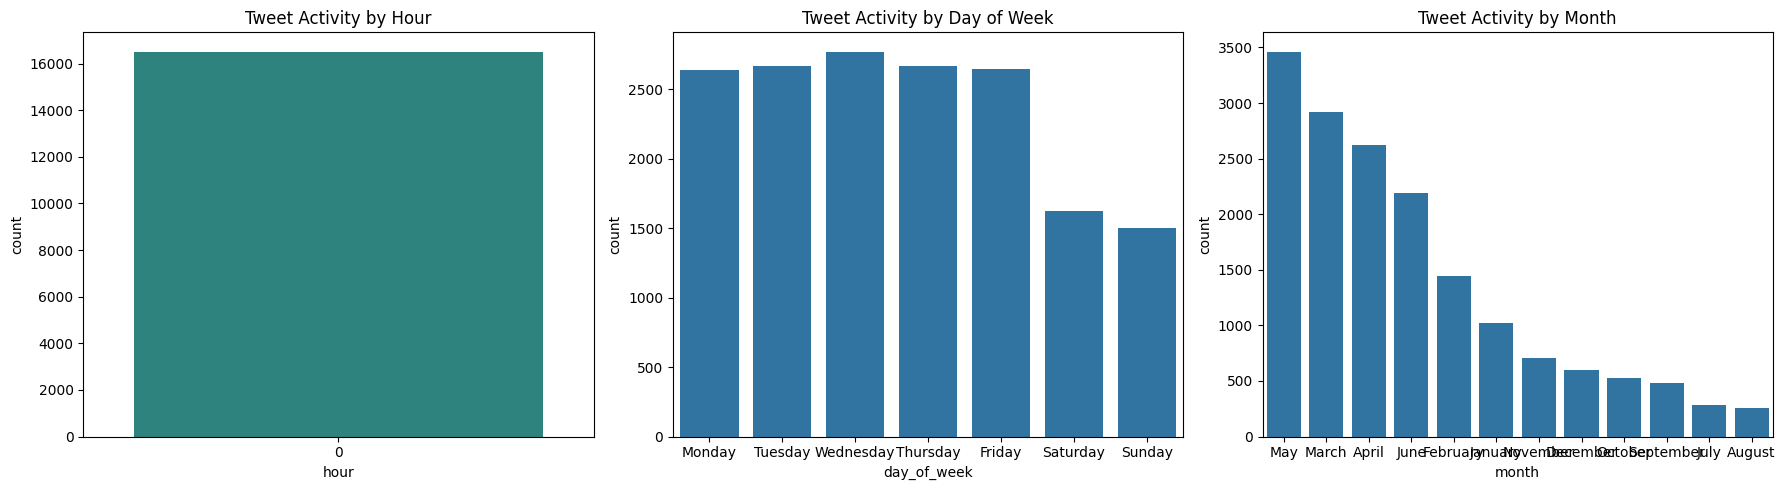

In [ ]:
# Convert to datetime
df['created_at'] = pd.to_datetime(df['created_at'])

# Extract time features
df['hour'] = df['created_at'].dt.hour
df['day_of_week'] = df['created_at'].dt.day_name()
df['month'] = df['created_at'].dt.month_name()

# Plot temporal patterns
plt.figure(figsize=(18,5))

# Hourly distribution
plt.subplot(1,3,1)
sns.countplot(x='hour', data=df, palette='viridis')
plt.title('Tweet Activity by Hour')

# Weekly distribution
plt.subplot(1,3,2)
sns.countplot(x='day_of_week', data=df,
             order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title('Tweet Activity by Day of Week')

# Monthly distribution
plt.subplot(1,3,3)
sns.countplot(x='month', data=df, order=df['month'].value_counts().index)
plt.title('Tweet Activity by Month')
plt.tight_layout()
plt.show()

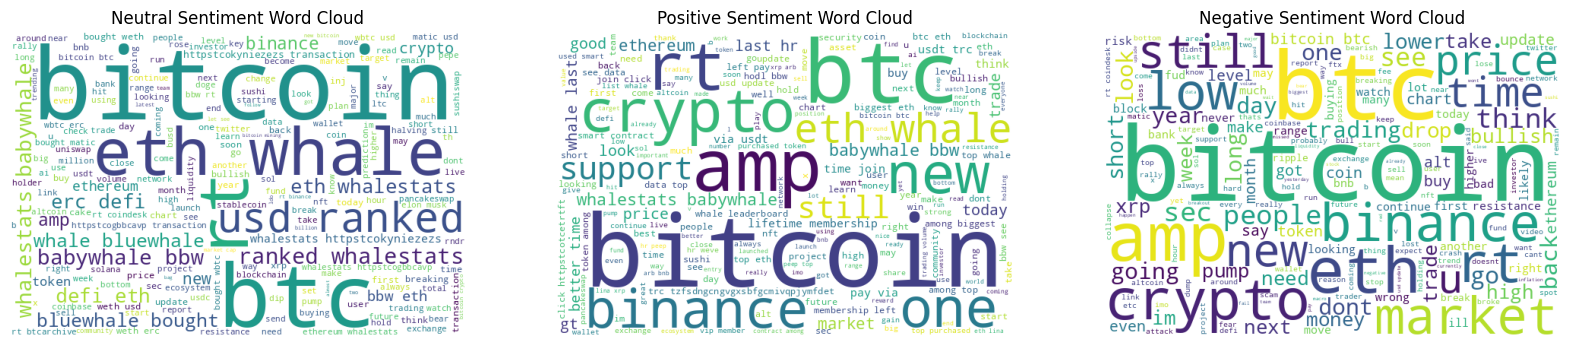

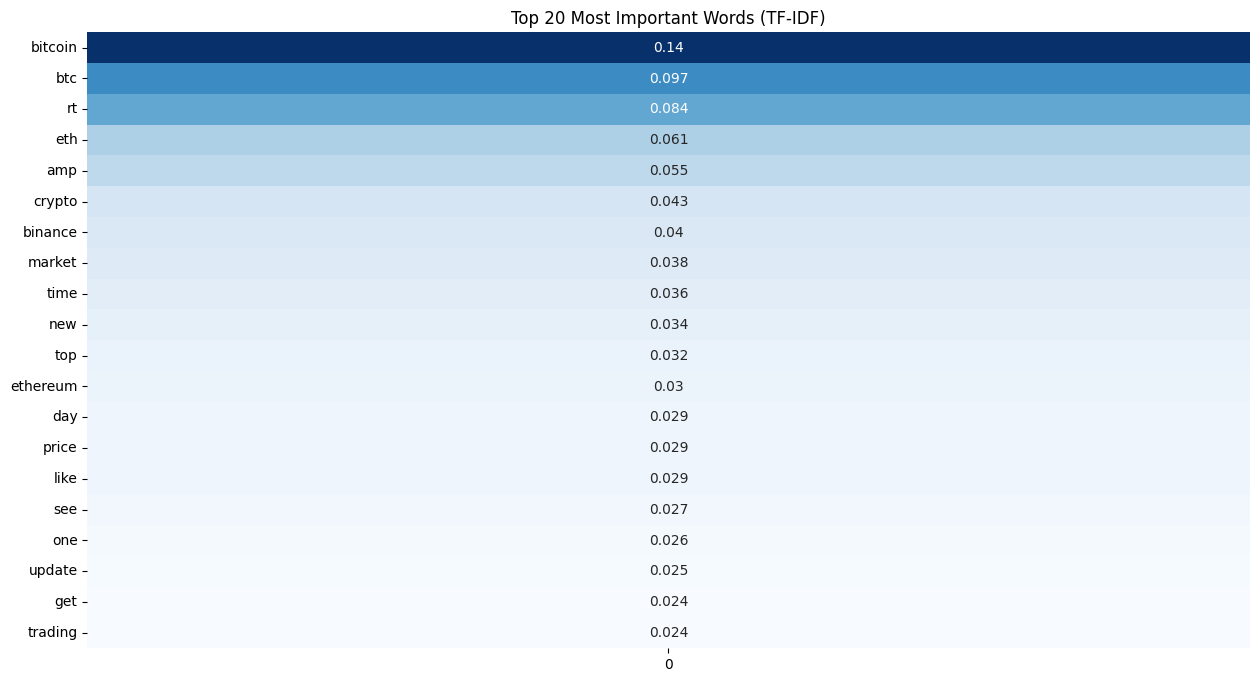

In [ ]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

# Generate word clouds for each sentiment
sentiments = df['sentiment'].unique()
plt.figure(figsize=(20,10))

for i, sentiment in enumerate(sentiments, 1):
    plt.subplot(1,len(sentiments),i)
    text = ' '.join(df[df['sentiment']==sentiment]['clean_text'])
    wordcloud = WordCloud(width=600, height=400, background_color='white').generate(text)
    plt.imshow(wordcloud)
    plt.title(f'{sentiment.capitalize()} Sentiment Word Cloud')
    plt.axis('off')
plt.show()

# TF-IDF Analysis
tfidf = TfidfVectorizer(max_features=50)
tfidf_matrix = tfidf.fit_transform(df['clean_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

plt.figure(figsize=(15,8))
sns.heatmap(tfidf_df.mean().sort_values(ascending=False).head(20).to_frame(),
            annot=True, cmap='Blues', cbar=False)
plt.title('Top 20 Most Important Words (TF-IDF)')
plt.show()

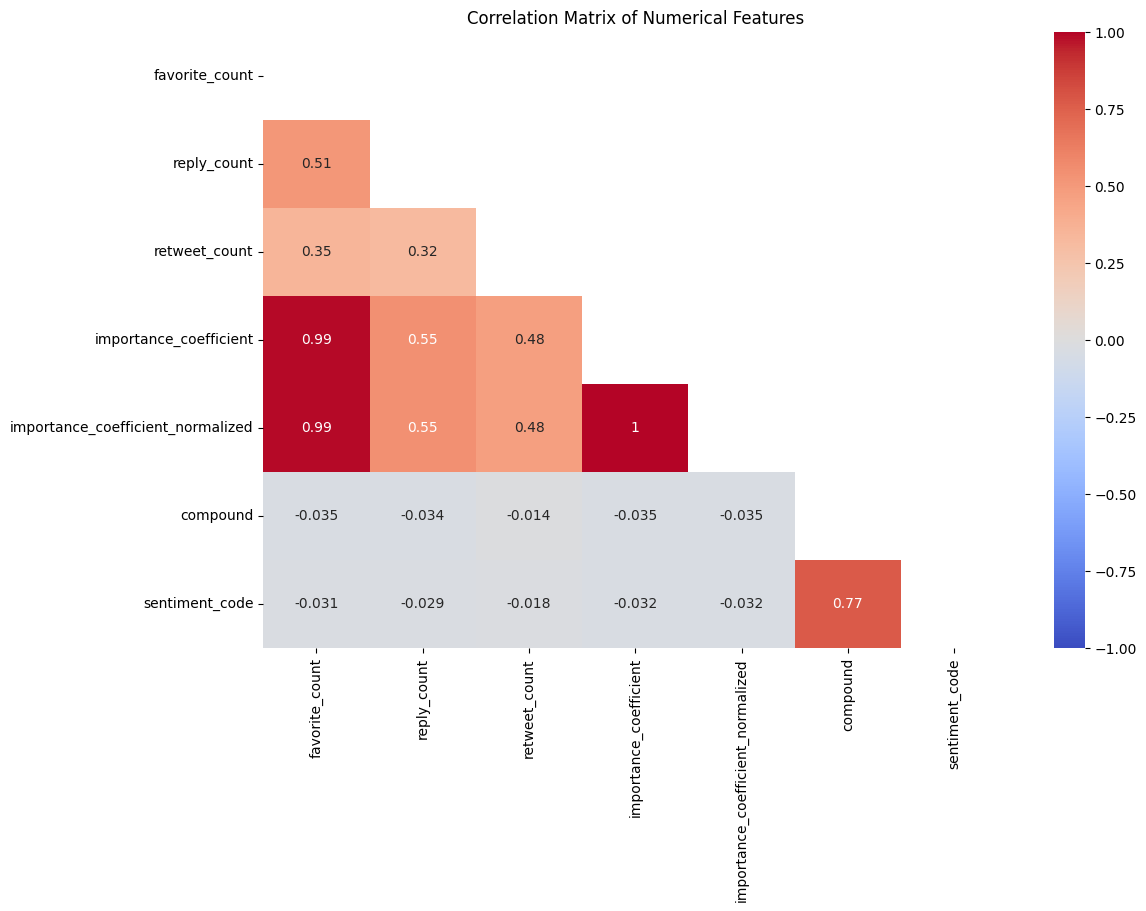

In [ ]:
# Convert categorical features to numerical
df['sentiment_code'] = df['sentiment'].astype('category').cat.codes

# Select numerical features
numerical_features = ['favorite_count', 'reply_count', 'retweet_count',
                     'importance_coefficient', 'importance_coefficient_normalized',
                     'compound', 'sentiment_code']

plt.figure(figsize=(12,8))
corr_matrix = df[numerical_features].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

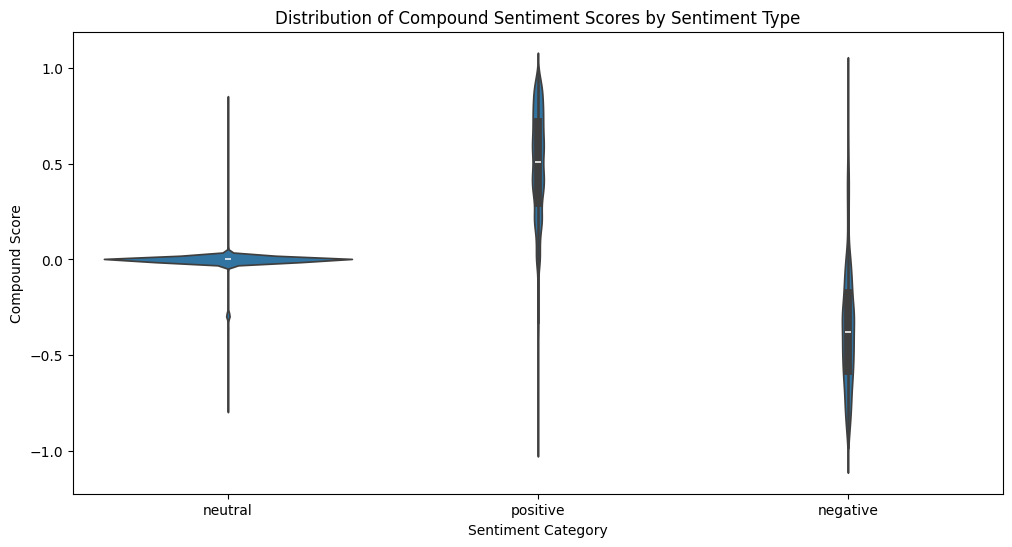

In [ ]:
plt.figure(figsize=(12,6))
sns.violinplot(x='sentiment', y='compound', data=df)
plt.title('Distribution of Compound Sentiment Scores by Sentiment Type')
plt.ylabel('Compound Score')
plt.xlabel('Sentiment Category')
plt.show()

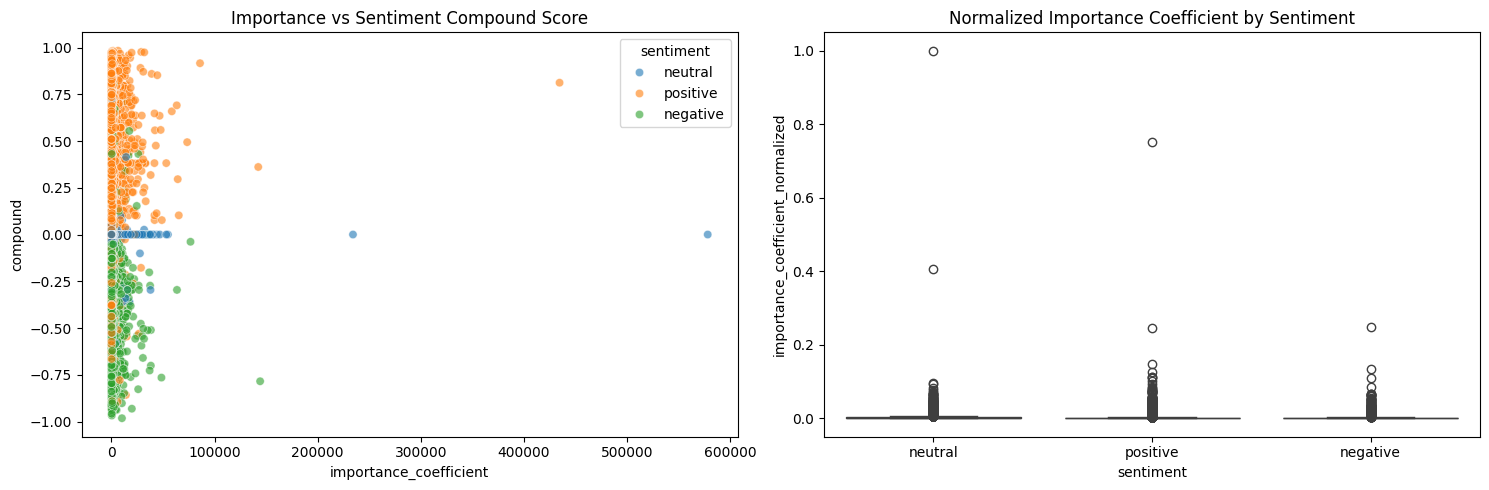

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.scatterplot(x='importance_coefficient', y='compound', hue='sentiment', data=df, alpha=0.6)
plt.title('Importance vs Sentiment Compound Score')

plt.subplot(1,2,2)
sns.boxplot(x='sentiment', y='importance_coefficient_normalized', data=df)
plt.title('Normalized Importance Coefficient by Sentiment')
plt.tight_layout()
plt.show()

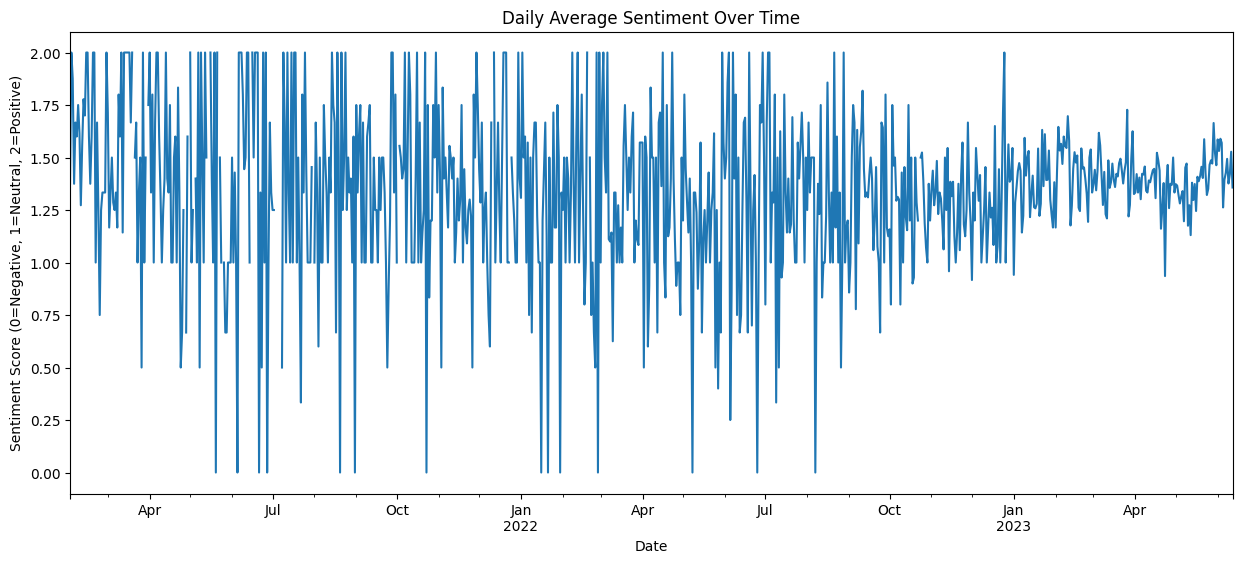

In [ ]:
# Resample to daily frequency
daily_sentiment = df.set_index('created_at').resample('D')['sentiment_code'].mean()

plt.figure(figsize=(15,6))
daily_sentiment.plot()
plt.title('Daily Average Sentiment Over Time')
plt.ylabel('Sentiment Score (0=Negative, 1=Neutral, 2=Positive)')
plt.xlabel('Date')
plt.show()

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    score = analyzer.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['clean_text'].apply(vader_sentiment)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# You need a labeled dataset for training this
# For example purposes, let’s assume df already has a 'label' column
X = df['clean_text']
y = df['sentiment']  # This must be labeled: 'positive', 'negative', 'neutral'

tfidf = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

preds = nb_model.predict(X_test)
print(classification_report(y_test, preds))


              precision    recall  f1-score   support

    negative       0.78      0.33      0.46       537
     neutral       0.83      0.40      0.54       966
    positive       0.66      0.96      0.78      1800

    accuracy                           0.69      3303
   macro avg       0.75      0.56      0.59      3303
weighted avg       0.73      0.69      0.66      3303



In [ ]:
!pip install transformers

from transformers import pipeline

# Load lightweight sentiment pipeline
classifier = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

def distilbert_sentiment(text):
    try:
        result = classifier(text[:512])[0]  # Truncate to 512 tokens
        return result['label'].lower()
    except:
        return 'neutral'

df['sentiment'] = df['clean_text'].apply(distilbert_sentiment)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


In [ ]:
import yfinance as yf
import pandas as pd

# Download Bitcoin data
btc = yf.download('BTC-USD', start='2022-01-01', end='2023-12-31')
# Force btc to have a single-level index with 'Date' as a column
btc = btc.reset_index()
print("btc DataFrame structure after download and reset_index:")
print(btc.head())  # Print the first few rows of btc
print(btc.columns) # Print the columns of btc

# Assuming 'created_at' is your date column in df
df['date'] = pd.to_datetime(df['created_at']).dt.date
btc['Date'] = pd.to_datetime(btc['Date']).dt.date

# Convert 'date' columns to strings
df['date'] = df['date'].astype(str)
btc['Date'] = btc['Date'].astype(str)

print("\ndf['date'] column details:")
print(df['date'].head())  # Print the first few values of df['date']
print(df['date'].dtype)  # Print the data type of df['date']

print("\nbtc['Date'] column details:")
print(btc['Date'].head())  # Print the first few values of btc['Date']
print(btc['Date'].dtype)  # Print the data type of btc['Date']

[*********************100%***********************]  1 of 1 completed

btc DataFrame structure after download and reset_index:
Price        Date         Close          High           Low          Open  \
Ticker                  BTC-USD       BTC-USD       BTC-USD       BTC-USD   
0      2022-01-01  47686.812500  47827.312500  46288.484375  46311.746094   
1      2022-01-02  47345.218750  47881.406250  46856.937500  47680.925781   
2      2022-01-03  46458.117188  47510.726562  45835.964844  47343.542969   
3      2022-01-04  45897.574219  47406.546875  45752.464844  46458.851562   
4      2022-01-05  43569.003906  46929.046875  42798.222656  45899.359375   

Price        Volume  
Ticker      BTC-USD  
0       24582667004  
1       27951569547  
2       33071628362  
3       42494677905  
4       36851084859  
MultiIndex([(  'Date',        ''),
            ( 'Close', 'BTC-USD'),
            (  'High', 'BTC-USD'),
            (   'Low', 'BTC-USD'),
            (  'Open', 'BTC-USD'),
            ('Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])



In [ ]:
# Calculate daily sentiment
daily_sentiment = df.groupby('date')['sentiment'].value_counts(normalize=True).unstack().fillna(0)
daily_sentiment = daily_sentiment.reset_index()

print("\ndaily_sentiment DataFrame structure:")
print(daily_sentiment.head())  # Print the first few rows of daily_sentiment
print(daily_sentiment.columns) # Print the columns of daily_sentiment


daily_sentiment DataFrame structure:
sentiment        date  negative  positive
0          2021-02-01     0.875     0.125
1          2021-02-02     1.000     0.000
2          2021-02-03     0.750     0.250
3          2021-02-04     0.750     0.250
4          2021-02-05     0.750     0.250
Index(['date', 'negative', 'positive'], dtype='object', name='sentiment')


In [ ]:
btc = btc.droplevel(level=0, axis=1) if isinstance(btc.columns, pd.MultiIndex) else btc  # Drop extra level if exists
daily_sentiment.columns = daily_sentiment.columns.get_level_values(0) if isinstance(daily_sentiment.columns, pd.MultiIndex) else daily_sentiment.columns # Drop extra level if exists


In [ ]:
import yfinance as yf
import pandas as pd

# Download Bitcoin data
btc = yf.download('BTC-USD', start='2022-01-01', end='2023-12-31')
# Force btc to have a single-level index with 'Date' as a column
btc = btc.reset_index()


df['date'] = pd.to_datetime(df['created_at']).dt.date
btc['Date'] = pd.to_datetime(btc['Date']).dt.date

# Convert 'date' columns to strings for merging
df['date'] = df['date'].astype(str)
btc['Date'] = btc['Date'].astype(str)

# Calculate daily sentiment
daily_sentiment = df.groupby('date')['sentiment'].value_counts(normalize=True).unstack().fillna(0)
daily_sentiment = daily_sentiment.reset_index()

# Ensure both 'Date' columns are at the same level and type
btc.columns = btc.columns.get_level_values(0) if isinstance(btc.columns, pd.MultiIndex) else btc.columns
daily_sentiment.columns = daily_sentiment.columns.get_level_values(0) if isinstance(daily_sentiment.columns, pd.MultiIndex) else daily_sentiment.columns

# Merge DataFrames using 'inner' join on 'Date' column
merged = pd.merge(btc, daily_sentiment, left_on='Date', right_on='date', how='inner')

# Drop the redundant 'date' column after merging
merged = merged.drop(columns=['date'])

# Print some info for debugging
print("btc columns:", btc.columns)
print("daily_sentiment columns:", daily_sentiment.columns)
print("merged columns:", merged.columns)



# Calculate and print correlation

# Ensure merged DataFrame has the expected columns
if 'Close' in merged.columns and 'positive' in merged.columns and 'negative' in merged.columns:
    correlation = merged[['Close', 'positive', 'negative']].corr()  # Include only available columns
    print("\nCorrelation Matrix:")
    print(correlation)
else:
    print("Error: Expected columns not found in merged DataFrame.")
# ---END MODIFIED SECTION--- #

[*********************100%***********************]  1 of 1 completed

btc columns: Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')
daily_sentiment columns: Index(['date', 'negative', 'positive'], dtype='object', name='sentiment')
merged columns: Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'negative',
       'positive'],
      dtype='object')

Correlation Matrix:
             Close  positive  negative
Close     1.000000 -0.125953  0.125953
positive -0.125953  1.000000 -1.000000
negative  0.125953 -1.000000  1.000000


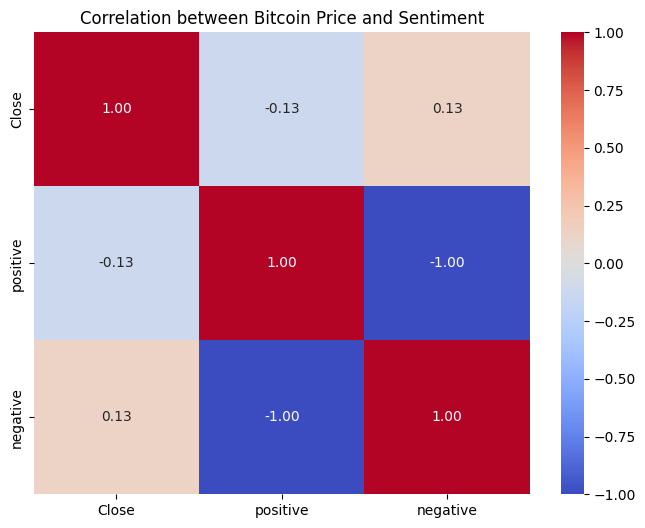

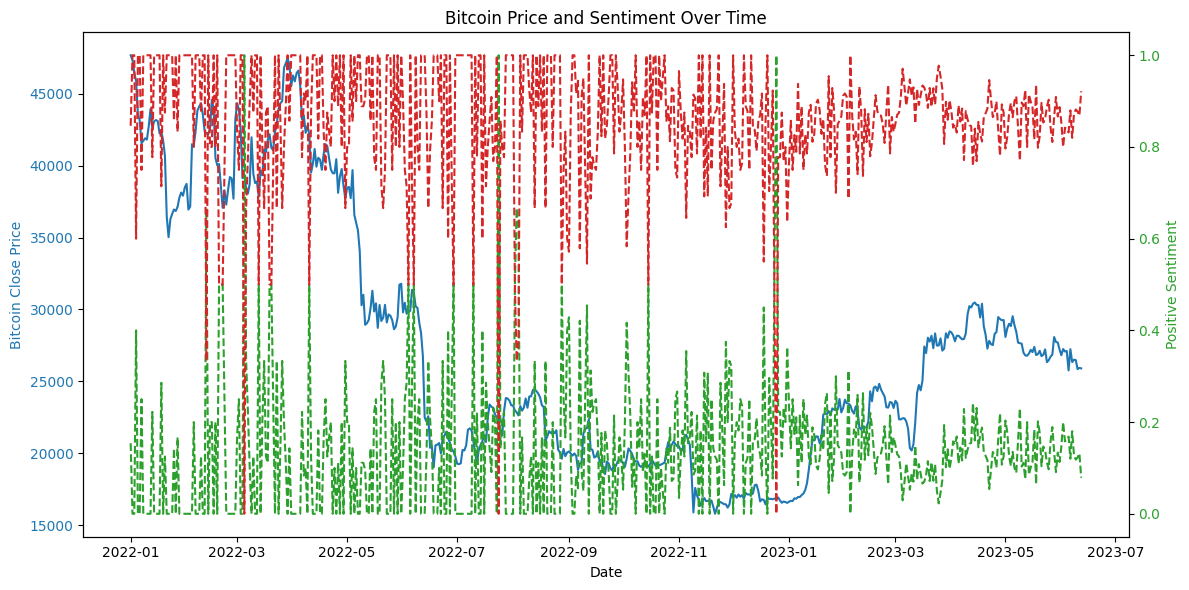

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap for correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Bitcoin Price and Sentiment')
plt.show()

# Line plots for Bitcoin price and sentiment scores over time
merged['Date'] = pd.to_datetime(merged['Date']) # Convert 'Date' column to datetime
merged.set_index('Date', inplace=True) # Set 'Date' as index

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Bitcoin closing price
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Bitcoin Close Price', color=color)
ax1.plot(merged['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for sentiment scores
ax2 = ax1.twinx()

# Plot positive sentiment score
color = 'tab:green'
ax2.set_ylabel('Positive Sentiment', color=color)
ax2.plot(merged['positive'], color=color, linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

# Plot negative sentiment score
color = 'tab:red'
ax2.plot(merged['negative'], color=color, linestyle='--')

# Add title and legend
plt.title('Bitcoin Price and Sentiment Over Time')
fig.tight_layout()
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

#  `X_tfidf` and `y` are already defined (from earlier step)
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

log_preds = logreg.predict(X_test)
print("Logistic Regression Results:\n", classification_report(y_test, log_preds))


Logistic Regression Results:
               precision    recall  f1-score   support

    negative       0.80      0.51      0.62       537
     neutral       0.82      0.79      0.81       966
    positive       0.82      0.93      0.87      1800

    accuracy                           0.82      3303
   macro avg       0.81      0.74      0.77      3303
weighted avg       0.82      0.82      0.81      3303

